# Perturbagen types 
### Navid Dianati

The goal is to investigate whether we can distinguish between different perturbagen types based on various signature-level metrics.

In this exercise, we will 
- load the signature information (siginfo) table
- inspect its contents
- extract a subset of its columns and process them into training and testing datasets
- train a multilayer perceptron classifier on the data
- evaluate the classification performance of the model

### Import packages, setup 

In [2]:
import pandas as pd
%load_ext autoreload
%autoreload 2
from cmapPy.pandasGEXpress import parse, write_gctx, GCToo
import os
import matplotlib.pyplot as plt
plt.style.use(['seaborn-pastel'])
plt.style.use(['seaborn-paper'])
from glob import glob
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import numpy as np
from scipy.stats import binned_statistic
import seaborn as sns
import statsmodels.robust 
import re
import logging
logger = logging.getLogger()
logging.basicConfig(level=logging.WARNING)

cmap_logger = logging.getLogger('cmap_logger')
cmap_logger.setLevel(logging.INFO)

# Constants

# Modz file for sample signatures from 4 pert_types:
# sh, oe, xpr, cp. Each 34,000 sigs
FILENAME_SAMPLE_MODZ_SH_OE_XPR_CP = "/srv/data/workshop/data/Module4/MODZ_sample_sigs_trt_sh_oe_xpr_cp_n=136000.gctx"

# Siginfo for the sample 
FILENAME_SAMPLE_SIGINFO = "/srv/data/workshop/data/Module4/siginfo.txt"

### Load the sample signatures from file

In [3]:
# gct = parse.parse(FILENAME_SAMPLE_MODZ_SH_OE_XPR_CP)

### Load the signature information (siginfo) table 

In [6]:
siginfo = pd.read_csv(FILENAME_SAMPLE_SIGINFO, sep="\t", index_col=0)
siginfo = siginfo[siginfo['pct_self_rank_q25']> -666]
print siginfo.shape

(116491, 30)


### What is in the siginfo table? 

In [7]:
siginfo.iloc[0,:]

pert_id                                                             BRD-A19500257
pert_iname                                                           geldanamycin
pert_type                                                                  trt_cp
pert_mfc_desc                                                        GELDANAMYCIN
cell_id                                                                      A549
pert_dose                                                                    0.24
pert_dose_unit                                                                 uM
pert_idose                                                                0.25 uM
pert_time                                                                      24
pert_time_unit                                                                  h
pert_itime                                                                   24 h
distil_cc_q75                                                                0.55
distil_ss       

### Select the features to explore

In [9]:
list_y = [
    "distil_cc_q75",
    "distil_ss",
#     "distil_tas",
    "median_recall_rank_spearman",
    "median_recall_rank_wtcs.50",
    "pct_self_rank_q25",
]

### Compare distributions of these metrics between the 4 pert types 

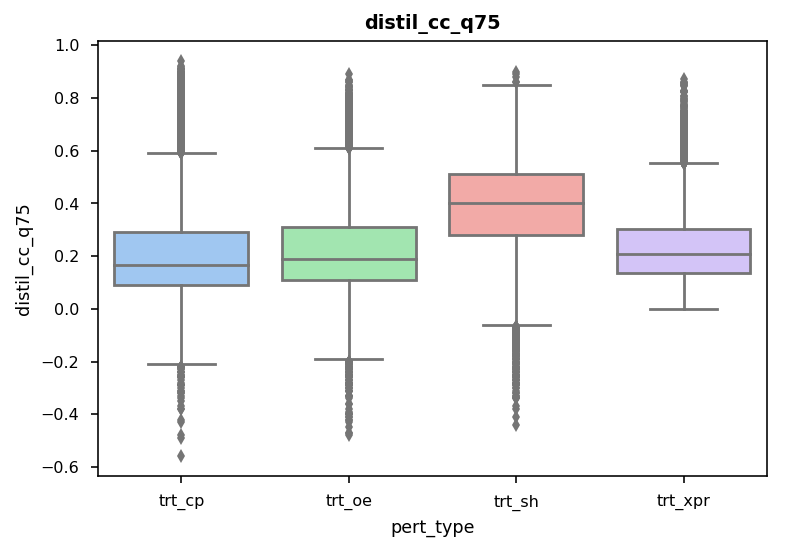

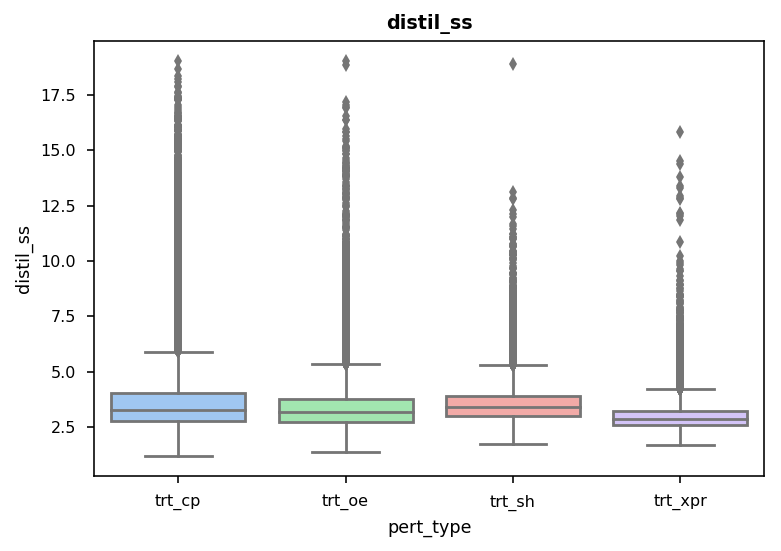

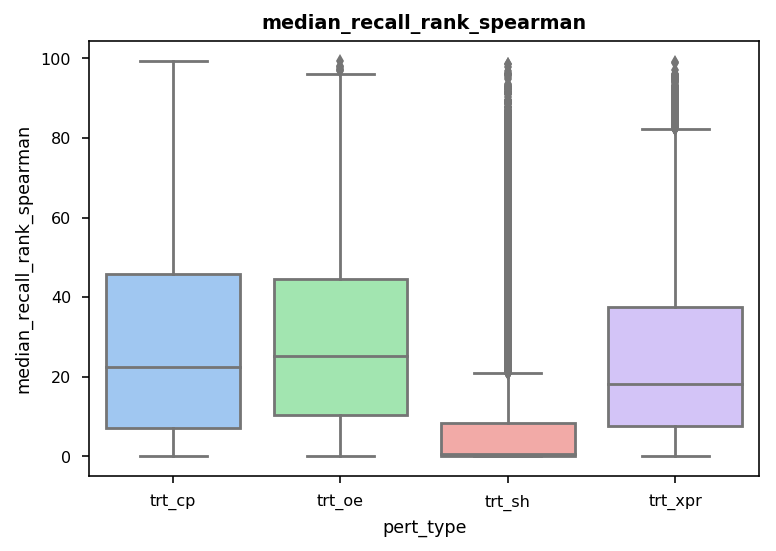

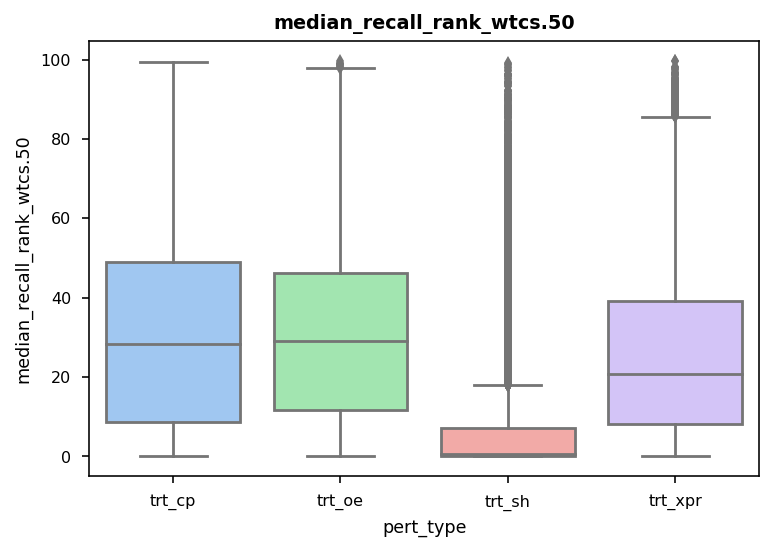

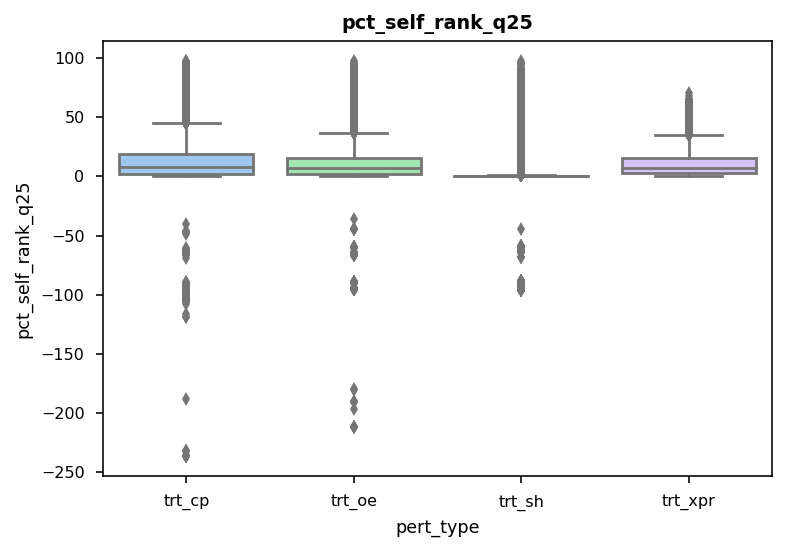

In [10]:
for y in list_y:
    plt.figure()
    data = siginfo[siginfo[y] != -666]
    sns.boxplot(
        x="pert_type",
        y=y,
        data = data
    )
    plt.title(y, fontweight="bold")

## Train a simple classifier using the signature-level features above 

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing.label import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE


### Prepare training data 

In [12]:
# Select list of fields to use as features
list_features = [
    "distil_cc_q75",
    "distil_ss",
    "median_recall_rank_spearman",
    "median_recall_rank_wtcs.50",
    "pct_self_rank_q25",
]

# append the target label
data = siginfo[list_features + ['pert_type']]

# Remove all data points with missingn values
data = data.replace(-666, np.nan)
data = data.replace(np.inf, np.nan)
data = data.dropna()
print "Number of data points: {}".format(len(data))

Number of data points: 115913


### Standardize the features,  encode the target labels as integers

In [13]:
data.loc[:,list_features][:] = StandardScaler().fit_transform(data[list_features].values)
labelencoder =  LabelEncoder()
data.loc[:, 'target'] = labelencoder.fit_transform(data['pert_type'])

### Inspect the training data

In [14]:
data = data[list_features + ['target']]
data.sample(5)

,distil_cc_q75,distil_ss,median_recall_rank_spearman,median_recall_rank_wtcs.50,pct_self_rank_q25,target
cid,,,,,,
KDB005_HA1E_96H:TRCN0000014740:-666,0.520,2.76176,0.00000,0.00000,0.000000,2
TA.OE003_A375_72H:BRDN0000464921:-666,0.050,3.55502,45.46160,44.70600,17.278400,1
KDA003_MCF7_96H:TRCN0000049411:-666,0.480,2.76708,0.00000,0.00000,0.000000,2
XPR026_HT29.311_96H:O19,0.501,4.00381,2.42281,5.53575,0.716204,3
KDD008_HEPG2_96H:TRCN0000040160:-666,0.500,3.78620,0.00000,0.00000,0.000000,2


### Split the data into training and testing sets

In [15]:
X, y = data[list_features].values, data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100000)

/opt/tljh/user/envs/py2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
print X_train.shape
print X_test.shape

(100000, 5)
(15913, 5)


# Multilayer Perceptron classifier  (MLP)

In [18]:
from sklearn.neural_network import MLPClassifier

In [19]:
mlp = MLPClassifier(
    hidden_layer_sizes=(7, 7, 7), max_iter=1000, alpha=0.001,
)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(7, 7, 7), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

### Optimize regularization factor


In [332]:
gs.cv_results_

{'mean_fit_time': array([  7.22430404,  12.13913099,  13.51305366,  13.7016689 ,
         17.86941457,  10.46205505,  10.32036599,  11.77974931,
         13.85899242,  11.82952364]),
 'mean_score_time': array([ 0.02653853,  0.02399103,  0.02514267,  0.02183199,  0.02957169,
         0.02832564,  0.02210259,  0.02748966,  0.02344664,  0.01719038]),
 'mean_test_score': array([-1.26497966, -1.16832064, -1.15108031, -1.13472549, -1.14610138,
        -1.151428  , -1.14961077, -1.13737327, -1.14433664, -1.13983536]),
 'mean_train_score': array([-1.26449734, -1.16646416, -1.14983428, -1.13310239, -1.14517408,
        -1.15241483, -1.14916588, -1.13695633, -1.14335653, -1.13854864]),
 'param_alpha': masked_array(data = [0.0001 0.00021544346900318845 0.00046415888336127773 0.001
  0.0021544346900318821 0.0046415888336127772 0.01 0.021544346900318822
  0.046415888336127774 0.10000000000000001],
              mask = [False False False False False False False False False False],
        fill_value

In [333]:
mlp = gs.best_estimator_
mlp

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 4, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Perform k-fold cross validation

# Support vector classifier

Optimze hypoerparameters using grid search

In [106]:
model.cv_results_

{'mean_fit_time': array([ 12.19443933,  13.29397066,  15.11967961]),
 'mean_score_time': array([ 1.99106097,  1.97646801,  1.96265833]),
 'mean_test_score': array([ 0.504  ,  0.50775,  0.5143 ]),
 'mean_train_score': array([ 0.54582485,  0.55384988,  0.56289983]),
 'param_C': masked_array(data = [20 30 50],
              mask = [False False False],
        fill_value = ?),
 'params': [{'C': 20}, {'C': 30}, {'C': 50}],
 'rank_test_score': array([3, 2, 1], dtype=int32),
 'split0_test_score': array([ 0.51064787,  0.51289742,  0.51679664]),
 'split0_train_score': array([ 0.54275428,  0.55145515,  0.55940594]),
 'split1_test_score': array([ 0.49654965,  0.49879988,  0.5090009 ]),
 'split1_train_score': array([ 0.54724764,  0.55444728,  0.56247188]),
 'split2_test_score': array([ 0.50480048,  0.51155116,  0.51710171]),
 'split2_train_score': array([ 0.54747263,  0.55564722,  0.56682166]),
 'std_fit_time': array([ 0.01386192,  0.02273249,  0.10264996]),
 'std_score_time': array([ 0.00532303, 

# Optimal SVC

In [107]:
svc = model.best_estimator_
svc

SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Train a model with the optimal hyperparameters

In [138]:
svc = SVC(C=50)
svc.fit(X_train, y_train)

SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

## Apply the model to the test set

In [20]:
# y_pred = svc.predict(X_test)
y_pred = mlp.predict(X_test)

## Compute the confusion matrix  

In [21]:
conf = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(
    conf, index=labelencoder.classes_, columns=labelencoder.classes_
)

In [22]:
df_conf

,trt_cp,trt_oe,trt_sh,trt_xpr
trt_cp,648,915,361,1008
trt_oe,355,1730,599,1576
trt_sh,167,331,3342,395
trt_xpr,168,640,313,3365


## Row-normalized confusion matrix 

In [23]:
df_conf_norm = df_conf.copy()
df_conf_norm[:] = df_conf.values.astype(float) / df_conf.values.sum(axis=1, keepdims=True)

In [24]:
df_conf_norm

,trt_cp,trt_oe,trt_sh,trt_xpr
trt_cp,0.221010,0.312074,0.123124,0.343793
trt_oe,0.083333,0.406103,0.140610,0.369953
trt_sh,0.039433,0.078158,0.789138,0.093270
trt_xpr,0.037450,0.142666,0.069773,0.750111


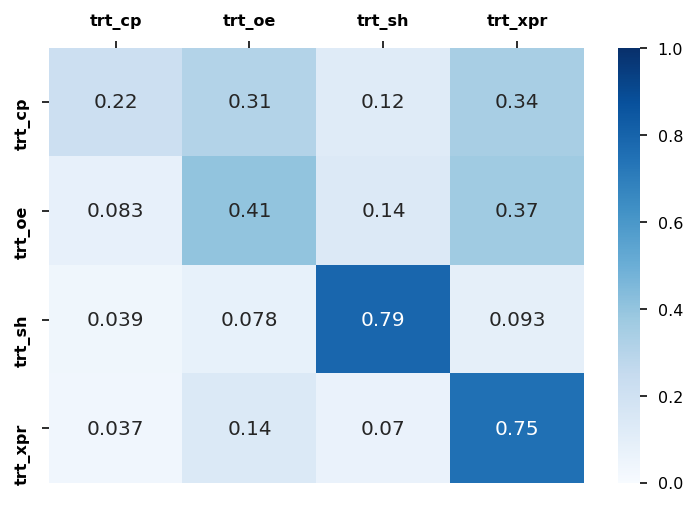

In [25]:
ax = sns.heatmap(data=df_conf_norm, cmap='Blues', annot=True, vmin=0, vmax=1)
ax.xaxis.tick_top()
_=ax.xaxis.set_ticklabels(df_conf_norm.columns, fontweight="bold")
_=ax.yaxis.set_ticklabels(df_conf_norm.index, fontweight="bold")

## Column-normalized confusion matrix 

In [22]:
df_conf_norm[:] = df_conf.values.astype(float) / df_conf.values.sum(axis=0)

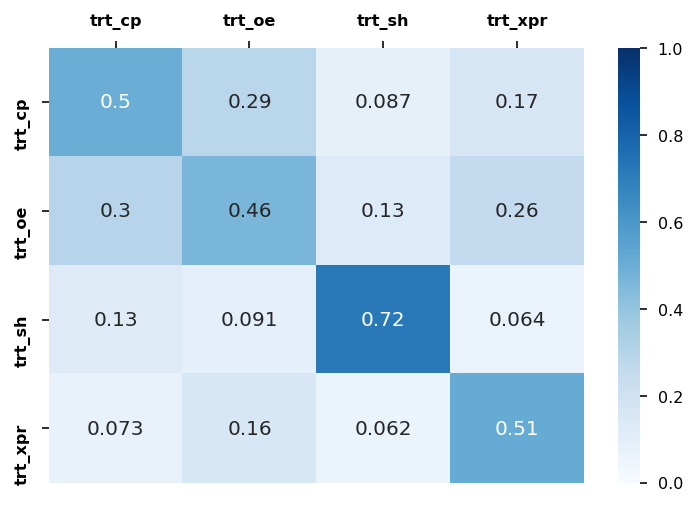

In [23]:
ax = sns.heatmap(data=df_conf_norm, cmap='Blues', annot=True, vmin=0, vmax=1)
ax.xaxis.tick_top()
_=ax.xaxis.set_ticklabels(df_conf_norm.columns, fontweight="bold")
_=ax.yaxis.set_ticklabels(df_conf_norm.index, fontweight="bold")

# Visualize the data using t-SNE

In [29]:

# data = pd.DataFrame(np.hstack([X, y[:,None]]), columns = list_features + ['label'])

def plot_tsne(data, perplexity):
    data_sample = data.sample(5000)
    data_sample
    n_features = data.shape[1] - 1
    XX = data_sample.iloc[:, :n_features]
    yy = data_sample.iloc[:, n_features]

    tsne = TSNE(perplexity=perplexity)
    XX_trans = tsne.fit_transform(XX)

    data_sample = pd.concat(
        [data_sample, pd.DataFrame(XX_trans, columns=['x', 'y'], index=data_sample.index)], axis=1)

    data_sample['pert_type'] = labelencoder.inverse_transform(data_sample['target'].astype(int))
    data_sample['size'] = 40
    plt.figure(figsize=(10,10))
    sns.scatterplot('x', 'y', 
                    hue='pert_type',
                    hue_order=sorted(data_sample['pert_type'].unique()),
                    data = data_sample, palette="Set1",
                   s=40,
                    lw=0
                   )
    plt.gca().set_aspect('equal')

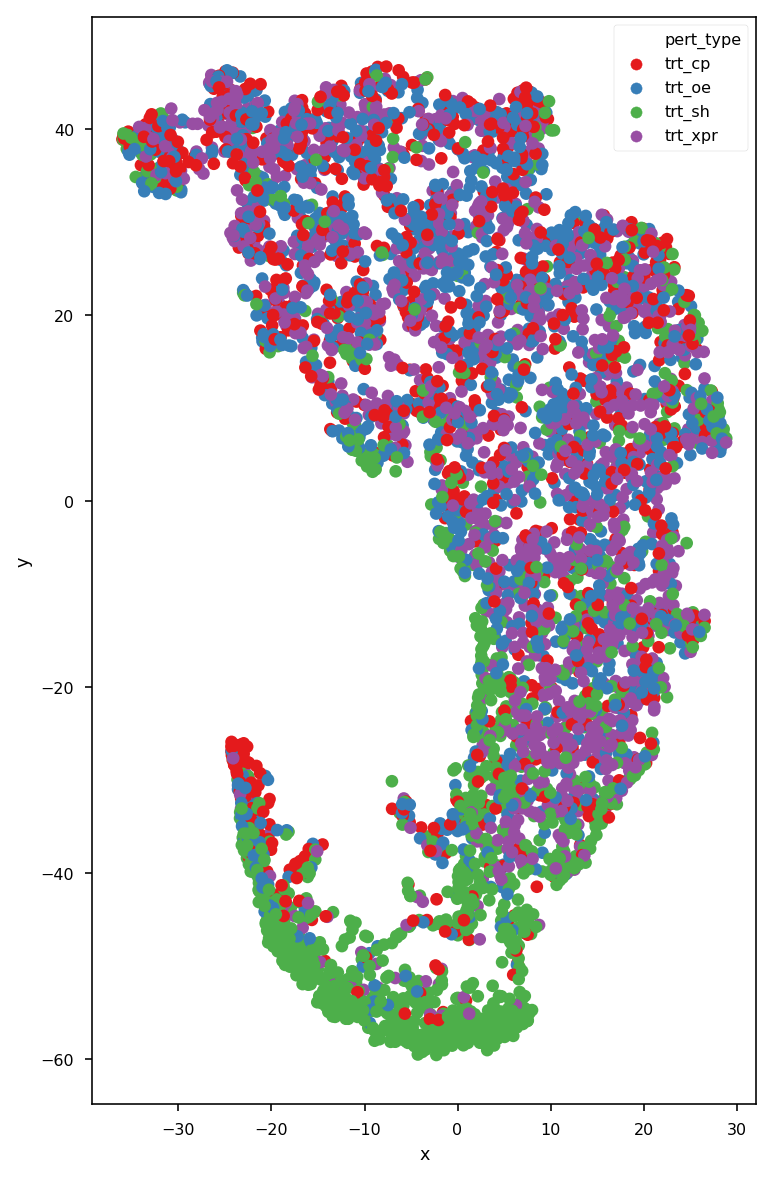

In [32]:
plot_tsne(data, perplexity=100)

In [33]:
data

,distil_cc_q75,distil_ss,median_recall_rank_spearman,median_recall_rank_wtcs.50,pct_self_rank_q25,target
cid,,,,,,
CRCGN005_A549_24H:BRD-A19500257:0.24,0.55,5.76326,0.398936,0.265957,0.198939,0
CRCGN007_A549_24H:BRD-A19500257:2.22,0.65,8.37480,0.265957,1.063830,0.088496,0
CRCGN005_A549_24H:BRD-A29800834:0.0823045,0.06,4.16046,40.577500,16.034800,30.415600,0
CRCGN007_A549_24H:BRD-A61273891:2.22222,0.14,4.37150,46.675500,32.845700,13.761100,0
CRCGN005_A549_24H:BRD-A75409952:0.08,0.14,3.74856,80.496500,58.052100,26.436800,0
CRCGN006_A549_24H:BRD-K04571198:2.22222,0.04,3.39703,62.077000,68.443500,32.027000,0
CRCGN006_A549_24H:BRD-K11433652:2.22222,0.07,3.51674,36.403100,35.470800,31.756800,0
CRCGN006_A549_24H:BRD-K13533483:6.66667,0.71,9.16099,0.135501,0.136240,0.090090,0
CRCGN007_A549_24H:BRD-K24315235:6.66667,0.52,7.19254,41.755300,44.148900,9.889380,0


### Scatter all features against one another 

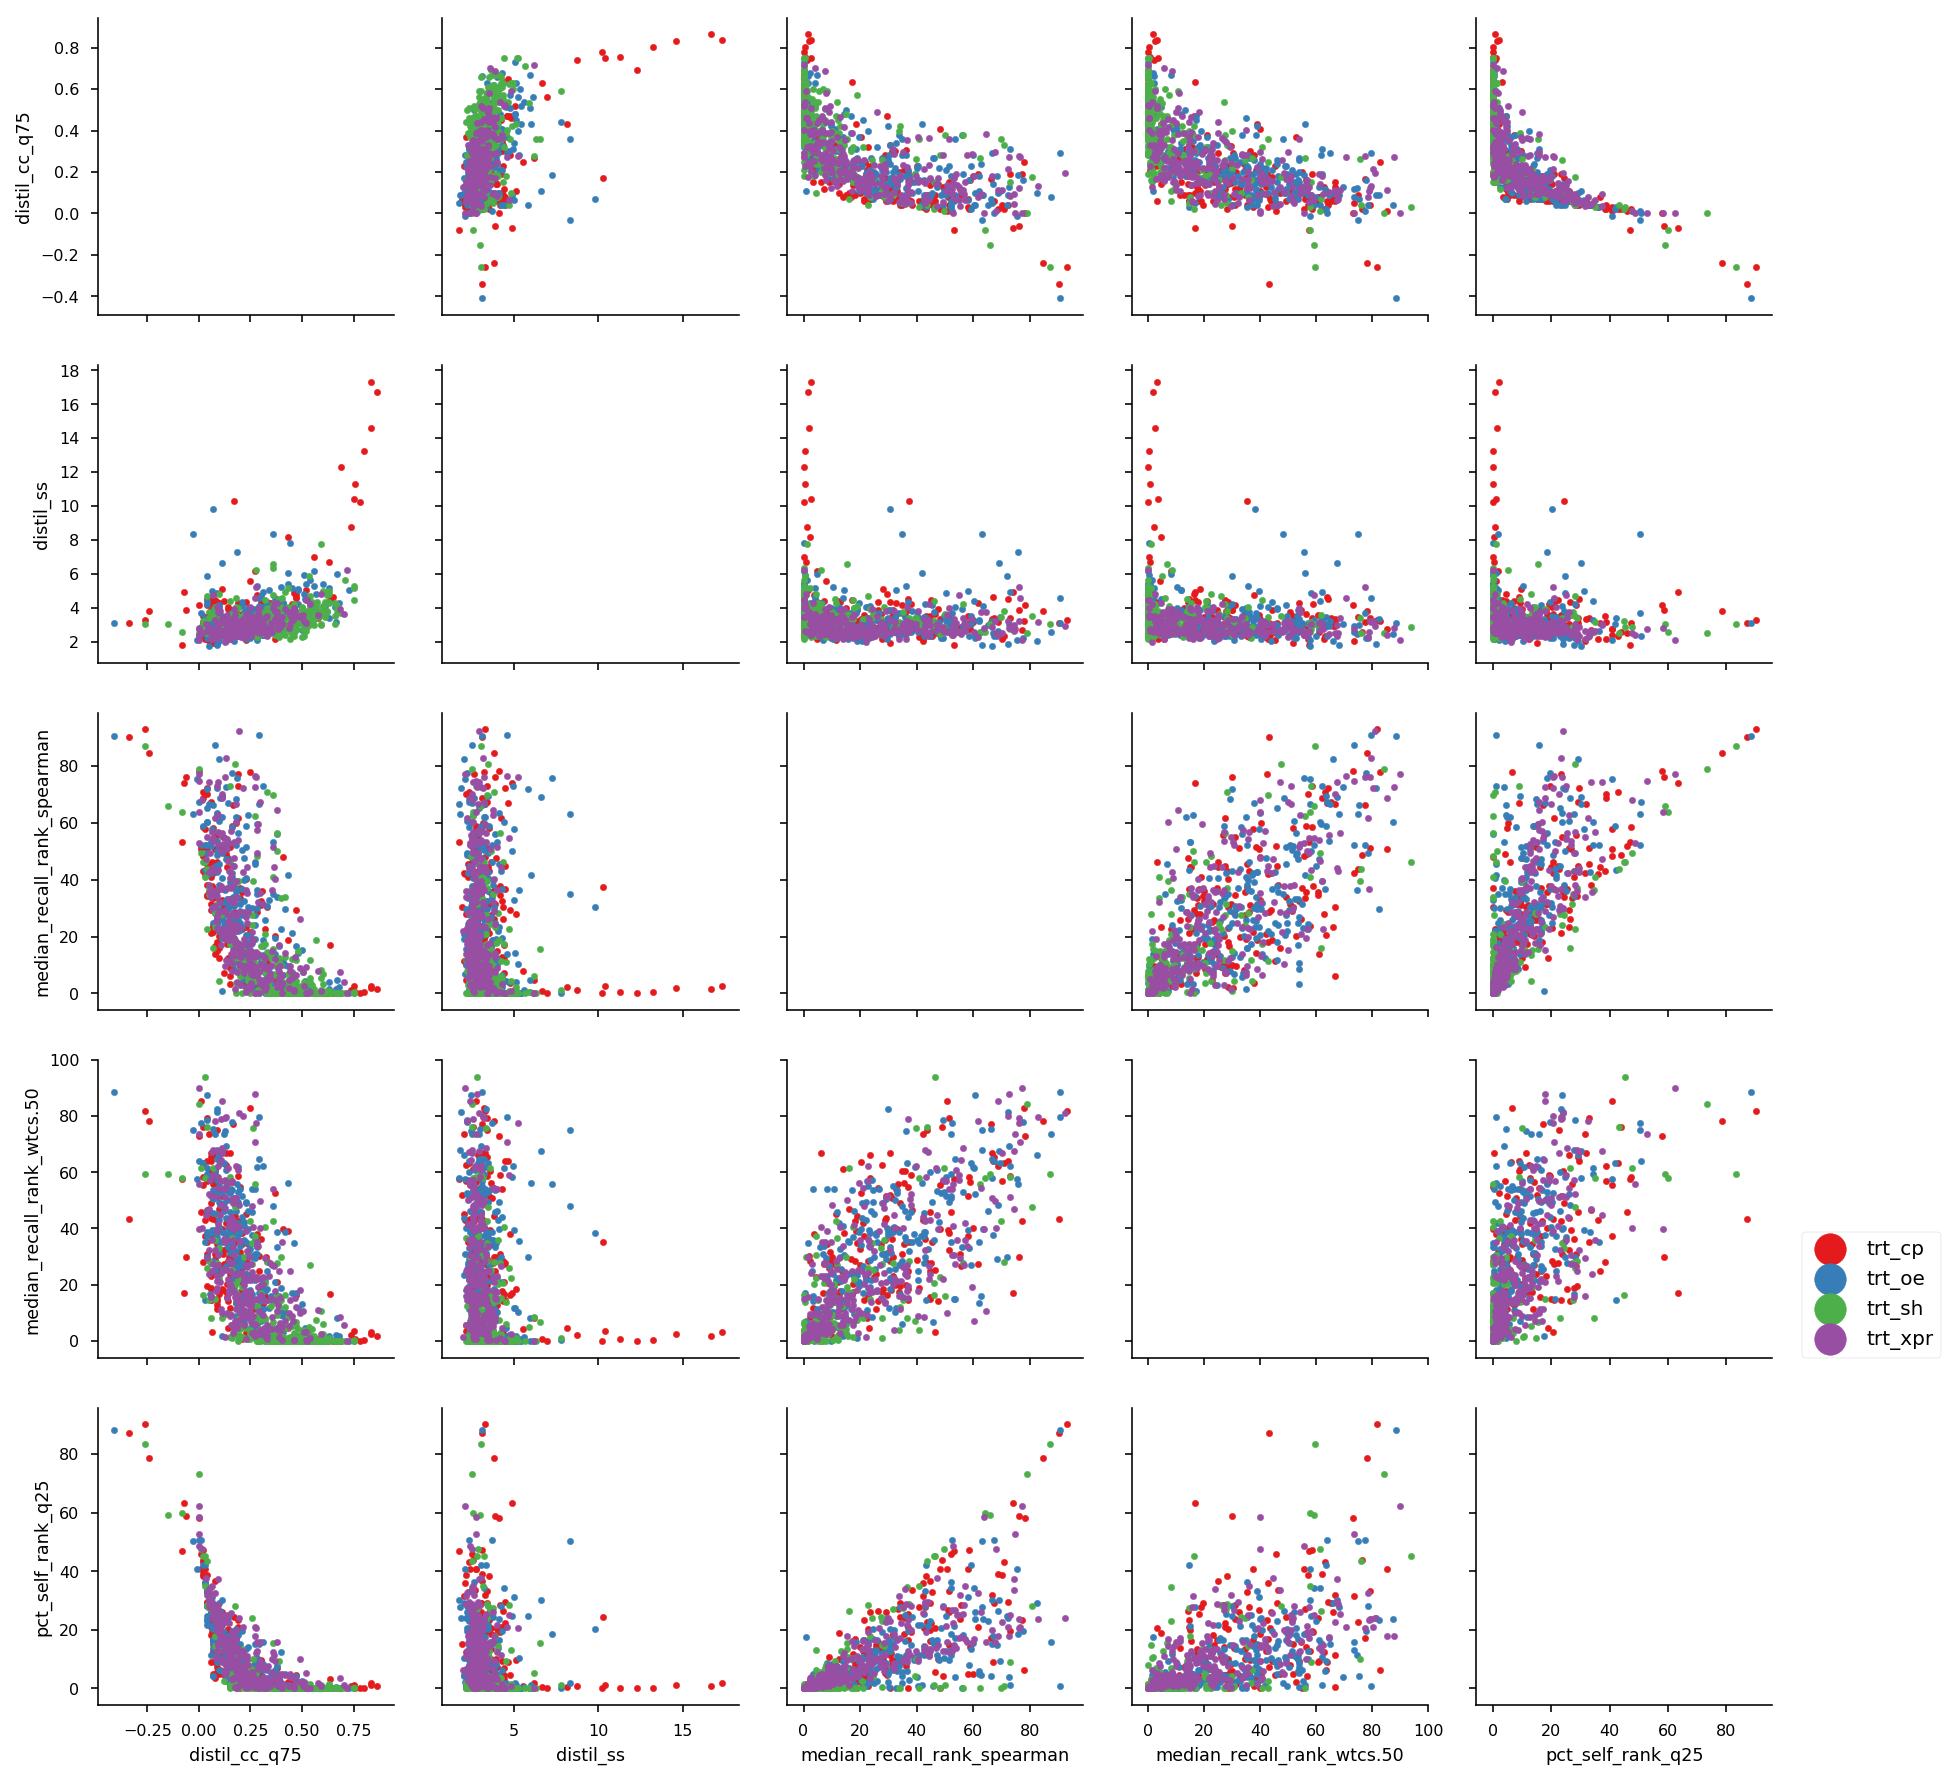

In [26]:
g = sns.PairGrid(data.sample(1000), vars=data.columns[:5], dropna=True, hue="target", palette="Set1")
g.map_offdiag(plt.scatter, alpha=1, s=10)
plt.legend(labelencoder.inverse_transform(range(len(data['target'].unique()))),
          loc=(1.1,0), fontsize=10, markerscale=5)